##Car_Plate_Recognition
Put a car image 'car.jpg' in the same folder.

In [ ]:
!apt install tesseract-ocr
!apt install libtesseract-dev
!apt-get install tesseract-ocr-eng 
!python -m pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-eng is already the newest version (4.00~git24-0e00fe6-1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

##1.Read image in grayscale

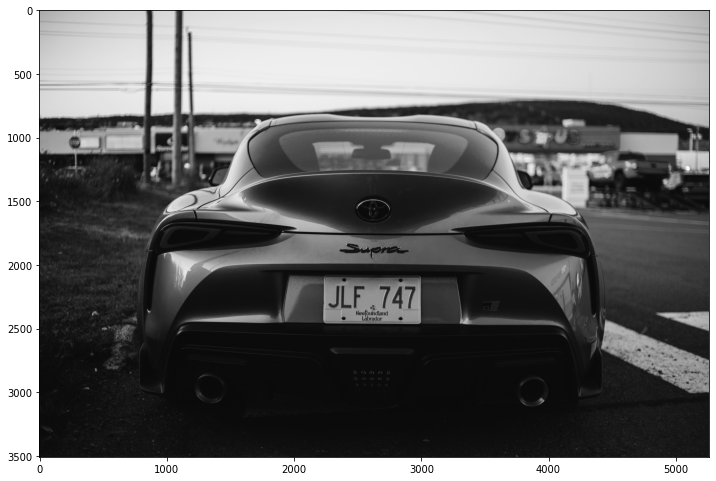

In [ ]:
img = cv2.imread("car.jpg")
img_ori = img.copy()
height, width, channel = img.shape 
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,12))
plt.imshow(img,cmap="gray")

##2.Make a black and white binary photo with adaptive threshold

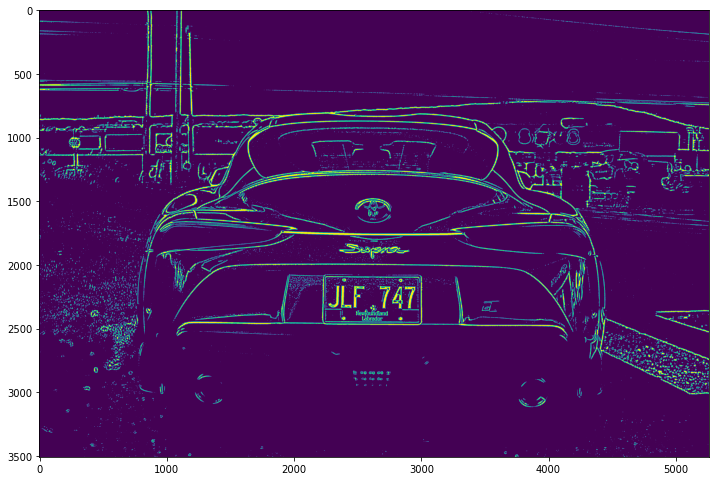

In [ ]:
img = cv2.GaussianBlur(img,ksize=(5,5),sigmaX=0)
img = cv2.adaptiveThreshold(
    img,
    maxValue=255.0,
    adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType = cv2.THRESH_BINARY_INV,
    blockSize = 31,
    C=5
)
plt.figure(figsize=(12,12))
plt.imshow(img)

##3.Find contours
Main point: contours

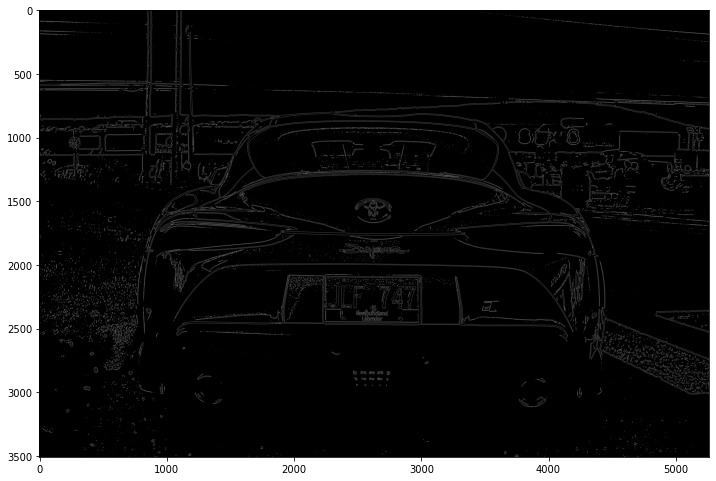

In [ ]:
contours, _ = cv2.findContours(
    img,
    mode = cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

blank = np.zeros((height,width,channel),dtype=np.uint8)
cv2.drawContours(blank, contours, -1, (255,255,255))
plt.figure(figsize=(12,12))
plt.imshow(blank)

##4.Find rectangles that bounds contours
Main point: contours_dict



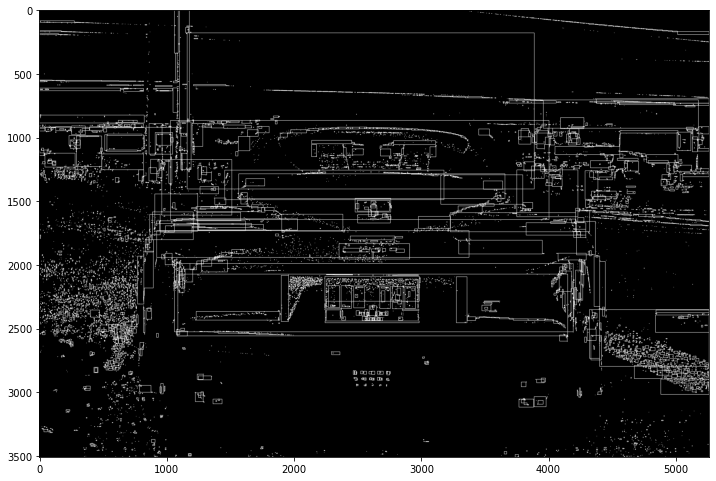

In [ ]:
blank = np.zeros((height,width,channel),np.uint8)
contours_dict = []
for contour in contours:
  x,y,w,h = cv2.boundingRect(contour)
  cv2.rectangle(blank,pt1=(x,y),pt2=(x+w,y+h), color=(255,255,255),thickness=2)
  contours_dict.append({
      'contour':contour,
      'x':x,
      'y':y,
      'w':w,
      'h':h,
      'cx':x+(w/2),
      'cy':y+(h/2)
  })

plt.figure(figsize=(12,12))
plt.imshow(blank)

##5.Filter out the rectangles within a certain range
Main point: possible_contours

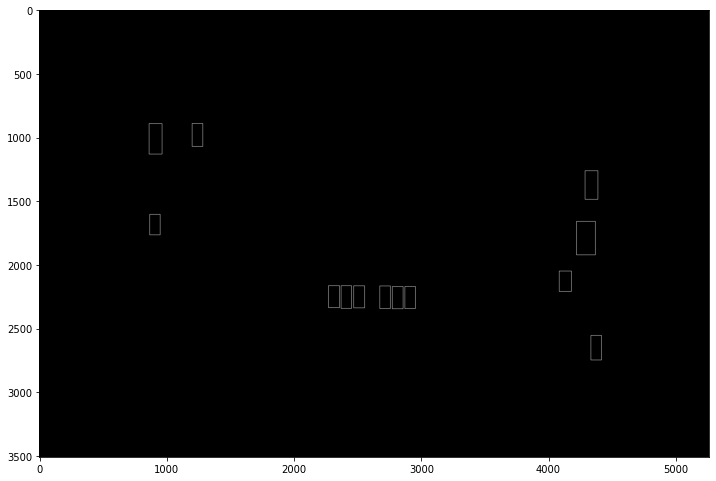

In [ ]:
MIN_AREA, MAX_AREA = 100*100, 400*100
MIN_RATIO, MAX_RATIO = 1.5, 3

possible_contours = []

index = 0

for d  in contours_dict:
  area = d['w'] * d['h']
  ratio = d['h'] / d['w'] 
  if MIN_AREA < area < MAX_AREA and MIN_RATIO < ratio < MAX_RATIO:
    d["idx"] = index
    index += 1
    possible_contours.append(d)

blank = np.zeros((height,width,channel),dtype=np.uint8)
for d in possible_contours:
  cv2.rectangle(blank,pt1=(d['x'],d['y']),pt2=(d['x']+d['w'],d['y']+d['h']),color=(255,255,255),thickness=2)

plt.figure(figsize=(12,12))
plt.imshow(blank)

##6.Filter out an array of rectangles based on the relationship between two rectangles
Main point: matched_result_idx, matched_chars

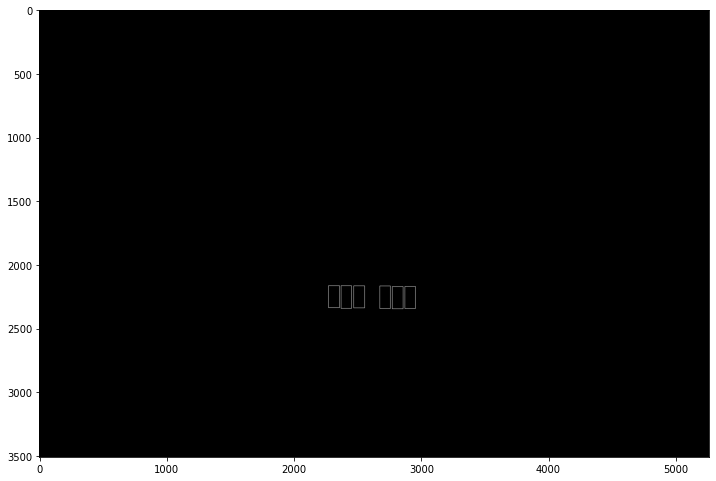

In [ ]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

def find_chars(contour_list):
  matched_result_idx = []

  for d1 in contour_list:
    matched_contours_idx = []
    for d2 in contour_list:
      if d1['idx'] == d2['idx']:
        continue
      dx = abs(d1['cx'] - d2['cx']) 
      dy = abs(d1['cy'] - d2['cy']) 
      diagonal_length1 = np.sqrt(d1['w']**2 + d1['h']**2) 
      distance = np.linalg.norm(np.array([d1['cx'],d2['cx']]) - np.array([d1['cy'],d2['cy']]))
      if dx == 0:
        angle_diff = 90
      else:
        angle_diff = np.degrees(np.arctan(dy/dx)) 

      area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
      width_diff = abs(d1['w'] - d2['w']) / d1['w']
      height_diff = abs(d1['h'] - d2['h']) / d1['h']

      if distance <  diagonal_length1 * MAX_DIAG_MULTIPLYER and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
        matched_contours_idx.append(d2['idx'])

    matched_contours_idx.append(d1['idx'])
    if len(matched_contours_idx) < MIN_N_MATCHED: 
      continue 

    matched_result_idx.append(matched_contours_idx) 
    unmatched_contour_idx = []
    for d4 in contour_list:
      if d4['idx'] not in matched_contours_idx:
        unmatched_contour_idx.append(d4['idx'])
    unmatched_contour = np.take(possible_contours, unmatched_contour_idx) 
    recursive_contour_list = find_chars(unmatched_contour)
    for idx in recursive_contour_list:
      matched_result_idx.append(idx)
    break
  return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
  matched_result.append(np.take(possible_contours, idx_list))

blank = np.zeros((height,width,channel),dtype=np.uint8)
for r in matched_result:
  for d in r:
    cv2.rectangle(blank, pt1=(d['x'],d['y']),pt2=(d['x']+d['w'],d['y']+d['h']),color=(255,255,255),thickness=2)

plt.figure(figsize=(12,12))
plt.imshow(blank)

##7.Arrange rectangles horizontally
Main point: plate_imgs, image_cropped

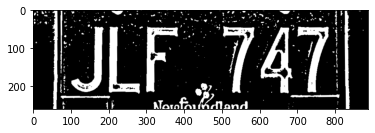

In [ ]:
PLATE_WIDTH_PADDING, PLATE_HEIGHT_PADDING = 1.3, 1.5 
MIN_PLATE_RATIO, MAX_PLATE_RATIO = 3, 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):

    sorted_chars = sorted(matched_chars, key=lambda x: x['cx']) 

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2 
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0 
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    


    img_rotated = cv2.warpAffine(img, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix( # 이미지 자르기
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)

    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')